<a href="https://colab.research.google.com/github/maliari0/Meyve-Taze/blob/main/Meyve_ve_Tazelik_Tahmini_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

dir_path = '/content/drive/My Drive/Colab Notebooks/Taze/dataset/train'
dir_path_test = '/content/drive/My Drive/Colab Notebooks/Taze/dataset/test'


Mounted at /content/drive


In [5]:
def load_data(dir_path):
    fruit_type_map = {
        'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2,
        'rottenapples': 0, 'rottenbanana': 1, 'rottenoranges': 2
    }
    freshness_map = {
        'freshapples': 0, 'freshbanana': 0, 'freshoranges': 0,
        'rottenapples': 1, 'rottenbanana': 1, 'rottenoranges': 1
    }
    data = []
    for category in fruit_type_map:
        path = os.path.join(dir_path, category)
        fruit_type_label = fruit_type_map[category]
        freshness_label = freshness_map[category]
        for img_name in tqdm(os.listdir(path)):
            if img_name.endswith('.png'):
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (100, 100))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                data.append([img, fruit_type_label, freshness_label])
    shuffle(data)
    X = []
    Y_fruit_type = []
    Y_freshness = []
    for features, fruit_type_label, freshness_label in data:
        X.append(features)
        Y_fruit_type.append(fruit_type_label)
        Y_freshness.append(freshness_label)
    return np.array(X), np.array(Y_fruit_type), np.array(Y_freshness)

# Load training data
X_train, Y_train_fruit_type, Y_train_freshness = load_data('/content/drive/My Drive/Colab Notebooks/Taze/dataset/train')

# Load validation data
X_val, Y_val_fruit_type, Y_val_freshness = load_data('/content/drive/My Drive/Colab Notebooks/Taze/dataset/test')

# Normalize the images
X_train = X_train / 255.0
X_val = X_val / 255.0


100%|██████████| 403/403 [00:22<00:00, 18.31it/s]


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, SeparableConv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils import to_categorical


# Pre-trained MobileNetV2 model
mobilenetv2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze the base model layers
for layer in mobilenetv2_model.layers:
    layer.trainable = False

# Build the model using Functional API
input_layer = mobilenetv2_model.input
x = mobilenetv2_model.output
x = BatchNormalization()(x)
x = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Meyve türü tahmini için çıkış katmanı
fruit_type_output = Dense(3, activation='softmax', name='fruit_type_output')(x)

# Tazelik tahmini için çıkış katmanı
freshness_output = Dense(1, activation='sigmoid', name='freshness_output')(x)

# Modeli birleştir
model = Model(inputs=input_layer, outputs=[fruit_type_output, freshness_output])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'fruit_type_output': 'categorical_crossentropy', 'freshness_output': 'binary_crossentropy'},
              metrics={'fruit_type_output': 'accuracy', 'freshness_output': 'accuracy'})

# Callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1, min_lr=0.00002)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Split data into training and validation sets
X_train, X_val, Y_train_fruit_type, Y_val_fruit_type, Y_train_freshness, Y_val_freshness = train_test_split(
    X_train, Y_train_fruit_type, Y_train_freshness, test_size=0.2, random_state=42)

Y_train_fruit_type = to_categorical(Y_train_fruit_type, num_classes=3)
Y_val_fruit_type = to_categorical(Y_val_fruit_type, num_classes=3)

# Train the model
history = model.fit(X_train, {'fruit_type_output': Y_train_fruit_type, 'freshness_output': Y_train_freshness},
                    validation_data=(X_val, {'fruit_type_output': Y_val_fruit_type, 'freshness_output': Y_val_freshness}),
                    epochs=20, batch_size=32, callbacks=[lr_reduce, checkpoint])


<ipython-input-10-bdd19c00c1b9>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenetv2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(100, 100, 3))


Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - freshness_output_accuracy: 0.7892 - fruit_type_output_accuracy: 0.8081 - loss: 0.8948
Epoch 1: val_loss improved from inf to 1.25451, saving model to best_model.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 100s 402ms/step - freshness_output_accuracy: 0.7897 - fruit_type_output_accuracy: 0.8086 - loss: 0.8931 - val_freshness_output_accuracy: 0.9346 - val_fruit_type_output_accuracy: 0.5992 - val_loss: 1.2545 - learning_rate: 0.0010
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - freshness_output_accuracy: 0.9677 - fruit_type_output_accuracy: 0.9707 - loss: 0.1941
Epoch 2: val_loss improved from 1.25451 to 0.22315, saving model to best_model.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 84s 386ms/step - freshness_output_accuracy: 0.9677 - fruit_type_output_accuracy: 0.9707 - loss: 0.1941 - val_freshness_output_accuracy: 0.9759 - val_fruit_type_output_accuracy: 0.9845 - val_loss: 0.2231 - learning_rate: 0.0010
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━

KeyError: 'accuracy'

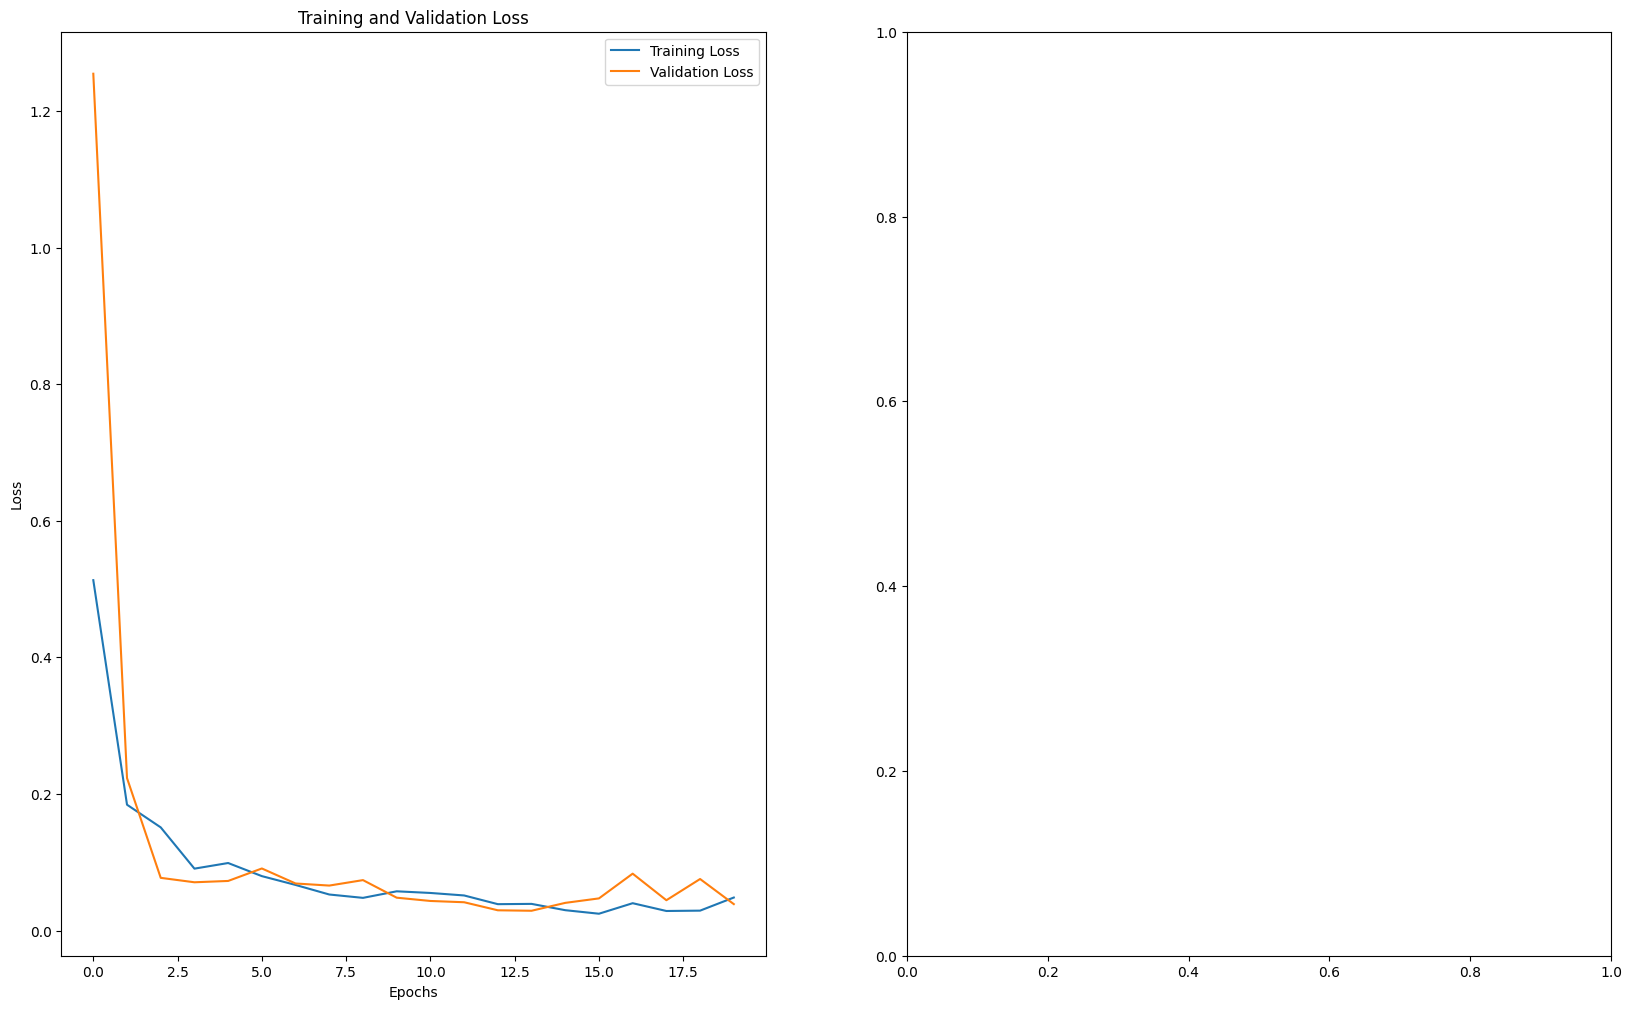

In [11]:
# Kısmen çalışmıyor. Kodlarda çok oynama yaptım. Fakat düzeltilebilir.

plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
# Şuan çalışmıyor. Kodlarda çok oynama yaptım. Fakat düzeltilebilir.

model.evaluate(X_test, Y_test)

test_img = X_test[0]
plt.imshow(test_img)
test_img = np.expand_dims(test_img, axis=0)
prediction = model.predict(test_img)
print('Prediction:', 'Çürük' if prediction > 0.5 else 'Taze')


In [18]:
from google.colab import files
from PIL import Image
import numpy as np

# Fotoğraf yükleme butonu oluşturma
uploaded = files.upload()

# Yüklenen fotoğrafı işleme
for file_name in uploaded.keys():
    img = Image.open(file_name)
    img = img.resize((100, 100))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    # Model ile tahmin yap
    predictions = model.predict(img)
    fruit_type_pred = np.argmax(predictions[0])
    freshness_pred = predictions[1][0]

    # Meyve türünü belirleme
    fruit_classes = ['Elma', 'Muz', 'Portakal']
    predicted_fruit = fruit_classes[fruit_type_pred]

    # Tazeliği belirleme
    if freshness_pred > 0.5:
        print(f'Bu meyve {predicted_fruit} ve çürük.')
    else:
        print(f'Bu meyve {predicted_fruit} ve taze.')


Saving rotten banana.jpg to rotten banana.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Bu meyve Muz ve çürük.


In [20]:
# Modeli kaydetme

model.save('/content/drive/My Drive/Colab Notebooks/Taze/SonModel.keras')


In [22]:
# Modeli yükleme

from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Colab Notebooks/Taze/SonModel.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 24 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
# Veri Kaydetme (NumPy): gereksiz zaten bu projede veriseti drive da bulunuyor.

import numpy as np

np.save('/content/drive/My Drive/Colab Notebooks/Taze/dataset.npy', dataset)


NameError: name 'dataset' is not defined

In [ ]:
# Veri yükleme NumPy

dataset = np.load('/content/drive/MyDrive/dataset.npy')
